<a href="https://www.kaggle.com/code/hydramst/water-pollution-lr?scriptVersionId=97975749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-pollution/Submission.csv
/kaggle/input/water-pollution/Target.csv
/kaggle/input/water-pollution/Train.csv
/kaggle/input/water-pollution/Test.csv


In [2]:
DF_train = pd.read_csv('/kaggle/input/water-pollution/Train.csv', delimiter = ',')
DF_test = pd.read_csv('/kaggle/input/water-pollution/Test.csv', delimiter = ',')
Target = pd.read_csv('/kaggle/input/water-pollution/Target.csv', delimiter = ',')
Submission = pd.read_csv('/kaggle/input/water-pollution/Submission.csv', delimiter = ',')

# Check if ID's in train presented in train

In [3]:
len(set(DF_train['id'].values).intersection(set(DF_test['id'].values)))/len(set(DF_test['id'].values))

0.6333333333333333

63% of test ID's presented in train

In [4]:
df_id = set(DF_train['id'].values).intersection(set(DF_test['id'].values))
DF_test[DF_test['id'].isin(df_id)]['id']
#DF_test = DF_test[DF_test['id'].isin(df_id)]

0                 FRHR326
3      DERW_DENW2742_0_16
5         SE667320-153747
7                 FRCR333
8                 ES12113
              ...        
116              FRHR216C
117            UKSC010040
118              FRHR216C
119               FRFR201
121               FRDR625
Name: id, Length: 78, dtype: object

### Concatinate train and test

In [5]:
df = pd.concat([DF_train, DF_test])

In [6]:
df = df.drop(columns = ['Unnamed: 0'])

## View categorical and numerical columns

In [7]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['code', 'period', 'id', 'Country'] 
 len =  4
numerical columns:	  ['year', 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
 len =  13


## Move 'year' to num columns 

In [8]:
cat_columns = ['code', 'period', 'id', 'Country', 'year']
num_columns = [ 'tourists', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 


## OHE 

In [9]:
df_ohe = pd.get_dummies(df[cat_columns])

In [10]:
df_all = pd.concat([df_ohe, df[num_columns]], axis=1)

# Scaling

In [11]:
# Creating StandardScaler Object
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df_all[num_columns]))
df_all = pd.concat([df_ohe.reset_index(drop=True), df_scale.reset_index(drop=True)], axis=1)
df_all

,year,code_CAS_14265-44-2,code_CAS_7723-14-0,period_2005-01--2005-12,period_2006-01--2006-12,period_2007-01--2007-12,period_2007-12--2008-02,period_2008-01--2008-12,period_2008-06--2008-08,period_2008-12--2009-02,...,0,1,2,3,4,5,6,7,8,9
0,2009,0,1,0,0,0,0,0,0,0,...,0.131908,2.000274,0.163134,-0.145253,-1.608173,-1.117183,-0.612535,-0.247726,-0.430640,-1.212528
1,2009,0,1,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
2,2009,1,0,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
3,2009,0,1,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
4,2009,0,1,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,2010,0,1,0,0,0,0,0,0,0,...,-0.879706,-1.300312,-1.514582,0.354700,0.618778,-0.176753,1.572949,-0.247726,0.341432,0.474821
2436,2010,0,1,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
2437,2010,1,0,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004
2438,2010,0,1,0,0,0,0,0,0,0,...,0.948287,0.263124,0.741657,-0.145253,0.273757,0.088497,-0.612535,-0.247726,-0.430640,-0.334004


## Split back to test and train 


In [12]:
len_test = len(DF_test)
train = df_all.iloc[:-len_test]
test = df_all.iloc[-len_test:]
print(DF_train.shape[0], train.shape[0], DF_test.shape[0], test.shape[0])

2318 2318 122 122


# Log Scaling 

In [13]:
#target_log = np.log(Target['polution'])
#target_log
target_orig = Target['polution']
len(pd.DataFrame(train))

2318

# Traintest split

In [14]:
X, y = pd.DataFrame(train).values, target_orig.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(1854, 464, 1854, 464)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1854, 1560), (464, 1560), (1854,), (464,))

# GridSearchCV

In [16]:
### define model
model = Ridge()

# define parameters
param = {
    'alpha':[0.000001, 1],
    'positive':[True, False],
    'copy_X':[True,False],
    'fit_intercept':[True,False]
    
}
grid = GridSearchCV(model, param, scoring='r2', cv=2, n_jobs=-1)
grid.fit(X_train, y_train)
predictions = grid.predict(X_test)
print('R2 : %.4f' %  r2_score(y_test,predictions))
print('R2 : %.4f' % grid.best_score_)

R2 : 0.3905
R2 : 0.1658


# ElasticNetCV

In [17]:
model_ElasticCV = ElasticNetCV(n_alphas=0.001, fit_intercept=True, max_iter=10000, l1_ratio=0.001)

#model_ElasticCV.fit(X_train, y_train)

#y_predict_Elastic = model_ElasticCV.predict(X_test)

#print('R2 : %.4f' %  r2_score(y_test,y_predict_Elastic))

# ElasticNet

In [18]:
model_Elastic = ElasticNet(alpha=0.00005, fit_intercept=True, max_iter=100000, l1_ratio=0.07)

model_Elastic.fit(X_train, y_train)

y_predict_Elastic = model_Elastic.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict_Elastic))

R2 : 0.4599


# Ridge LR

In [19]:

model = Ridge(alpha = 0.1, fit_intercept=True, max_iter=10000)

model.fit(X_train, y_train)

y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0
RMSE: 0.1
R2 : 0.4510


# Lasso

In [20]:
model_L = Lasso(alpha=0.00001, fit_intercept=True)

model_L.fit(X_train, y_train)
y_predict=model_L.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict))

R2 : 0.4411


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e-01, tolerance: 2.959e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Compare answers with original values

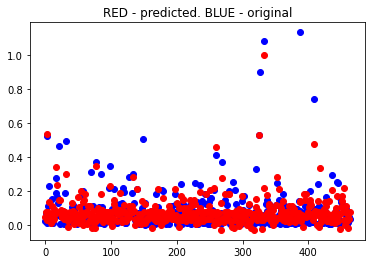

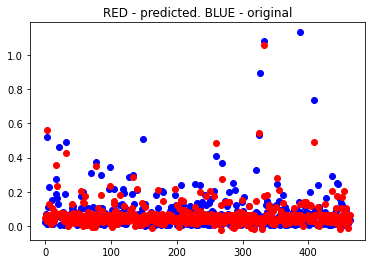

In [21]:
def plotGraph(y_test,y_predict,regressorName):
    if max(y_test) >= max(y_predict):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_predict))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_predict)), y_predict, color='red')
    plt.title(regressorName)
    plt.show()
    return


plotGraph(y_test, y_predict_Elastic, "RED - predicted. BLUE - original")
plotGraph(y_test, y_predict, "RED - predicted. BLUE - original")

# Cross validation

In [22]:
def cross_val(model, X_train, y_train):
  scoring = {'R2': 'r2',
            '-MSE': 'neg_mean_squared_error',
            '-MAE': 'neg_mean_absolute_error',
            'Max': 'max_error'}


  scores = cross_validate(model, X_train, y_train,
                        scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

  print('Результаты Кросс-валидации')
  DF_cv_linreg = pd.DataFrame(scores)
  display(DF_cv_linreg)
  print('\n')
  print(DF_cv_linreg.mean()[2:])
  print('\n')

cross_val(model_Elastic, X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.50658e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.82214e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.82214e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.50658e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,91.778775,0.003141,0.136061,-0.008165,-0.045859,-0.571055
1,73.676768,0.003015,0.404622,-0.008015,-0.046784,-0.514040
2,92.634176,0.007259,0.518159,-0.004051,-0.041490,-0.250359
3,93.528671,0.003451,0.295737,-0.007784,-0.042101,-0.790334
4,83.000041,0.006890,0.386634,-0.006550,-0.042365,-0.518394




test_R2      0.348242
test_-MSE   -0.006913
test_-MAE   -0.043720
test_Max    -0.528836
dtype: float64




In [23]:
model = Ridge(alpha=0.0001, max_iter=10000)

model.fit(X_train, y_train)

y_predict = model_Elastic.predict(test)

#y_predict = np.exp(y_predict)
Submission['polution'] = y_predict
Submission

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,idx,polution
0,402,0.075759
1,748,0.072960
2,763,0.072960
3,942,0.075269
4,1258,0.037373
...,...,...
117,19447,0.237725
118,19458,0.097955
119,19464,0.035895
120,19699,0.069691


In [24]:
! rm /kaggle/working/water-pollution/Submission.csv
! mkdir /kaggle/working/water-pollution/
Submission['polution'][27] = 2.0

rm: cannot remove '/kaggle/working/water-pollution/Submission.csv': No such file or directory


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
Submission.to_csv('/kaggle/working/water-pollution/Submission.csv',index=False)

In [26]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"hydramst","key": "" }' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [27]:
cat ~/.kaggle/kaggle.json

{"username":"hydramst","key": "" }


In [28]:
#! kaggle competitions submit -f /kaggle/working/water-pollution/Submission.csv -m "Message" sf-matml-2022-regression